# The NEST `noise_generator`

#### Hans Ekkehard Plesser, 2015-06-25

This notebook describes how the NEST `noise_generator` model works and what effect it has on model neurons.

NEST needs to be in your `PYTHONPATH` to run this notebook.

## Basics

The `noise_generator` emits 

1. a piecewise constant current 
1. that changes at fixed intervals $\delta$. 
1. For each interval, a new amplitude is chosen from the normal distribution.
1. Each target neuron receives a different realization of the current.

To be precise, the output current of the generator is given by

$$I(t) = \mu + \sigma N_j \qquad\text{with $j$ such that}\quad j\delta < t \leq (j+1)\delta$$

where $N_j$ is the value drawn from the zero-mean unit-variance normal distribution for interval $j$ containing $t$.  

When using the generator with modulated variance, the noise current is given by

$$I(t) = \mu + \sqrt{\sigma^2 + \sigma_m^2\sin(2\pi f j\delta + \frac{2\pi}{360}\phi_d)} N_j \;.$$

Mathematical symbols match model parameters as follows

|Symbol|Parameter|Unit|Default|Description|
|------|:--------|:---|------:|:----------|
|$\mu$|`mean`|pA|0 pA|mean of the noise current amplitude|
|$\sigma$|`std`|pA|0 pA|standard deviation of the noise current amplitude|
|$\sigma_m$|`std_mod`|pA|0 pA|modulation depth of the std. deviation of the noise current amplitude|
|$\delta$|`dt`|ms|1 ms|interval between current amplitude changes|
|$f$|`frequency`|Hz|0 Hz| frequency of variance modulation|
|$\phi_d$|`phase`|[deg]|0$^{\circ}$| phase of variance modulation|

For the remainder of this document, we will only consider the current at time points $t_j=j\delta$ and define

$$I_j = I(t_j+) = \mu + \sigma N_j $$

and correspondingly for the case of modulated noise. Note that $I_j$ is thus the current emitted during $(t_j, t_{j+1}]$, following NEST's use of left-open, right-closed intervals. We also set $\omega=2\pi f$ and $\phi=\frac{2\pi}{360}\phi_d$ for brevity.

### Properties of the noise current

1. The noise current is a *piecewise constant* current. Thus, it is only an approximation to white noise and the properties of the noise will depend on the update interval $\delta$. The default update interval is $\delta = 1$ms. We chose this value so that the default would be independent from the time step $h$ of the simulation, assuming that time steps larger than 1 ms are rarely used. It also is plausible to assume that most time steps chosen will divide 1 ms evenly, so that changes in current amplitude will coincide with time steps. If this is not the case, the subsequent analysis does not apply exactly.
1. The currents to all targets of a noise generator have different amplitudes, but always change simultaneously at times $j\delta$.
1. Across an ensemble of targets or realizations, we have
\begin{align}
\langle I_j\rangle &= \mu \\
\langle \Delta I_j^2\rangle &= \sigma^2 \qquad \text{without modulation} \\
\langle \Delta I_j^2\rangle &= \sigma^2 + \sigma_m^2\sin( \omega j\delta + \phi) \qquad \text{with modulation.} 
\end{align}
1. Without modulation, the autocorrelation of the noise is given by
$$\langle (I_j-\mu) (I_k-\mu)\rangle = \sigma^2\delta_{jk}$$
where $\delta_{jk}$ is Kronecker's delta.
1. With modulation, the autocorrlation is
$$\langle (I_j-\mu) (I_k-\mu)\rangle = \sigma_j^2\delta_{jk}\qquad\text{where}\; \sigma_j = \sqrt{\sigma^2 + \sigma_m^2\sin( j\delta\omega + \phi_d)}\;.$$
Note that it is currently not possible to record this noise current directly in NEST, since a `multimeter` cannot record from a `noise_generator`.

## Noise generators effect on a neuron

Precisely how a current injected into a neuron will affect that neuron, will obviously depend on the neuron itself. We consider here the subthreshold dynamics most widely used in NEST, namely the leaky integrator. The analysis that follows is applicable directly to all `iaf_psc_*` models. It applies to conductance based neurons such as the `iaf_cond_*` models only as long as no synaptic input is present, which changes the membrane conductances.

### Membrane potential dynamics

We focus here only on subthreshold dynamics, i.e., we assume that the firing threshold of the neuron is $V_{\text{th}}=\infty$. We also ignore all synaptic input, which is valid for linear models, and set the resting potential $E_L=0$ mV for convenience. The membrane potential $V$ is then governed by

$$\dot{V} = - \frac{V}{\tau} + \frac{I}{C}$$

where $\tau$ is the membrane time constant and $C$ the capacitance. We further assume $V(0)=0$ mV. We now focus on the membrane potential at times $t_j=j\delta$. Let $V_j=V(j\delta)$ be the membrane potential at time $t_j$. Then, a constant currant $I_j$ will be applied to the neuron until $t_{j+1}=t_j+\delta$, at which time the membrane potential will be

$$V_{j+1} = V_j e^{-\delta/\tau} + \left(1-e^{-\delta/\tau}\right)\frac{I_j\tau}{C} \;.$$

We can apply this backward in time towards $V_0=0$

\begin{align}
V_{j+1} &= V_j e^{-\delta/\tau} + \left(1-e^{-\delta/\tau}\right)\frac{I_j\tau}{C} \\
  &= \left[V_{j-1} e^{-\delta/\tau} + \left(1-e^{-\delta/\tau}\right)\frac{I_{j-1}\tau}{C}\right]
     e^{-\delta/\tau} + \left(1-e^{-\delta/\tau}\right)\frac{I_j\tau}{C} \\
  &= \left(1-e^{-\delta/\tau}\right)\frac{\tau}{C}\sum_{k=0}^{j} I_k e^{-(j-k)\delta/\tau} \\
  &= \left(1-e^{-\delta/\tau}\right)\frac{\tau}{C}\sum_{k=0}^{j} I_{k} e^{-k\delta/\tau} \;.
\end{align}

In the last step, we exploited the mutual independence of the random current amplitudes $I_k$, which allows us to renumber them arbitratily.

### Mean and variance of the membrane potential

The mean of the membrane potential at $t_{j+1}$ is thus

\begin{align}
\langle V_{j+1}\rangle &= \left(1-e^{-\delta/\tau}\right)\frac{\tau}{C}\sum_{k=0}^{j} \langle I_{k} \rangle e^{-k\delta/\tau}\\
 &= \frac{\mu\tau}{C}\left(1-e^{-\delta/\tau}\right)\sum_{k=0}^{j} e^{-k\delta/\tau}\\
 &= \frac{\mu\tau}{C}\left(1-e^{-(j+1)\delta/\tau}\right)\\
 &= \frac{\mu\tau}{C}\left(1-e^{-t_{j+1}/\tau}\right)
\end{align}

as expected; note that we used the geometric sum formula in the second step.

To obtain the variance of the membrane potential at $t_{j+1}$, we first compute the second moment

$$\langle V_{j+1}^2 \rangle = \frac{\tau^2}{C^2}\left(1-e^{-\delta/\tau}\right)^2 \left\langle\left(\sum_{k=0}^{j} I_{k} e^{-k\delta/\tau}\right)^2\right\rangle$$

Substituting $q = e^{-\delta/\tau}$ and $\alpha = \frac{\tau^2}{C^2}\left(1-e^{-\delta/\tau}\right)^2= \frac{\tau^2}{C^2}\left(1-q\right)^2$ and , we have

\begin{align}
\langle V_{j+1}^2 \rangle &= \alpha \left\langle\left(\sum_{k=0}^{j} I_{k} q^k\right)^2\right\rangle \\
  &= \alpha \sum_{k=0}^{j} \sum_{m=0}^{j} \langle I_k I_m \rangle q^{k+m} \\
  &= \alpha \sum_{k=0}^{j} \sum_{m=0}^{j} (\mu^2 + \sigma_k^2 \delta_{km}) q^{k+m} \\
  &= \alpha \mu^2 \left(\sum_{k=0}^j q^k\right)^2 + \alpha \sum_{k=0}^{j} \sigma_k^2  q^{2k} \\
  &= \langle V_{j+1}\rangle^2 + \alpha \sum_{k=0}^{j} \sigma_k^2  q^{2k} \;.
\end{align}

Evaluating the remaining sum for the modulate case will be tedious, so we focus for now on the unmodulated case, i.e., $\sigma\equiv\sigma_k$, so that we again are left with a geometric sum, this time over $q^2$. We can now subtract the square of the mean to obtain the variance

\begin{align}
\langle (\Delta V_{j+1})^2 \rangle &= \langle V_{j+1}^2 \rangle - \langle V_{j+1}\rangle^2 \\
   &= \alpha \sigma^2 \frac{q^{2(j+1)}-1}{q^2-1} \\
  &= \frac{\sigma^2\tau^2}{C^2} (1-q)^2 \frac{q^{2(j+1)}-1}{q^2-1} \\
  &= \frac{\sigma^2\tau^2}{C^2} \frac{1-q}{1+q}\left(1-q^{2(j+1)}\right) \\
  &=  \frac{\sigma^2\tau^2}{C^2} \frac{1-e^{-\delta/\tau}}{1+e^{-\delta/\tau}}\left(1-e^{-2t_{j+1}/\tau}\right) \;.
\end{align}

In the last step, we used that $1-q^2=(1-q)(1+q)$.

The last term in this expression describes the approach of the variance of the membrane potential to its steady-state value. The fraction in front of it describes the effect of switching current amplitudes at intervals $\delta$ instead of instantenously as in real white noise. 

We now have in the long-term limit

$$\langle (\Delta V)^2 \rangle = \lim_{j\to\infty} \langle (\Delta V_{j+1})^2 \rangle 
  = \frac{\sigma^2\tau^2}{C^2} \frac{1-e^{-\delta/\tau}}{1+e^{-\delta/\tau}} \;. $$
  
We expand the fraction:

In [1]:
import sympy
sympy.init_printing()
x = sympy.Symbol('x')
sympy.series((1-sympy.exp(-x))/(1+sympy.exp(-x)), x)

We thus have for $\delta \ll \tau$ and $t\gg\tau$

$$\langle (\Delta V)^2 \rangle 
  \approx \frac{\delta\tau \sigma^2 }{2 C^2} \;.$$

### How to obtain a specific mean and variance of the potential

In order to obtain a specific mean membrane potential $\bar{V}$ with standard deviation $\Sigma$ for given neuron parameters $\tau$ and $C$ and fixed current-update interval $\delta$, we invert the expressions obtained above.

For the mean, we have for $t\to\infty$

$$\langle V\rangle = \frac{\mu\tau}{C} \qquad\Rightarrow\qquad \mu = \frac{C}{\tau} \bar{V}$$

and for the standard deviation

$$\langle (\Delta V)^2 \rangle  \approx \frac{\delta\tau \sigma^2 }{2 C^2}
\qquad\Rightarrow\qquad  \sigma = \sqrt{\frac{2}{\delta\tau}}C\Sigma \;.$$

## Tests and examples

We will now test the expressions derived above against NEST. We first define some helper functions.

In [2]:
import math
import numpy as np
import scipy
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
def noise_params(V_mean, V_std, dt=1.0, tau_m=10., C_m=250.):
    'Returns mean and std for noise generator for parameters provided; defaults for iaf_psc_alpha.'
    
    return C_m / tau_m * V_mean, math.sqrt(2/(tau_m*dt))*C_m*V_std

In [4]:
def V_asymptotic(mu, sigma, dt=1.0, tau_m=10., C_m=250.):
    'Returns asymptotic mean and std of V_m'
    
    V_mean = mu * tau_m / C_m
    V_std = (sigma * tau_m / C_m) * np.sqrt(( 1 - math.exp(-dt/tau_m) ) / ( 1 + math.exp(-dt/tau_m) ))
                                    
    return V_mean, V_std

In [5]:
def V_mean(t, mu, tau_m=10., C_m=250.):
    'Returns predicted voltage for given times and parameters.'
    
    vm, _ = V_asymptotic(mu, sigma, tau_m=tau_m, C_m=C_m)
    return vm * ( 1 - np.exp( - t / tau_m ) )

In [6]:
def V_std(t, sigma, dt=1.0, tau_m=10., C_m=250.):
    'Returns predicted variance for given times and parameters.'
    
    _, vms = V_asymptotic(mu, sigma, dt=dt, tau_m=tau_m, C_m=C_m)
    return vms * np.sqrt(1 - np.exp(-2*t/tau_m))

In [7]:
import nest

def simulate(mu, sigma, dt=1.0, tau_m=10., C_m=250., N=1000, t_max=50.):
    '''
    Simulate an ensemble of N iaf_psc_alpha neurons driven by noise_generator.
    
    Returns
    - voltage matrix, one column per neuron
    - time axis indexing matrix rows
    - time shift due to delay, time at which first current arrives
    '''
    
    resolution = 0.1
    delay = 1.0

    nest.ResetKernel()
    nest.SetKernelStatus({'resolution': resolution})
    ng = nest.Create('noise_generator', params={'mean': mu, 'std': sigma, 'dt': dt})
    vm = nest.Create('voltmeter', params={'interval': resolution})
    nrns = nest.Create('iaf_psc_alpha', N, params={'E_L': 0., 'V_m': 0., 'V_th': 1e6,
                                                   'tau_m': tau_m, 'C_m': C_m})
    nest.Connect(ng, nrns, syn_spec={'delay': delay})
    nest.Connect(vm, nrns)
    
    nest.Simulate(t_max)
    
    # convert data into time axis vector and matrix with one column per neuron
    t, s, v = vm.events['times'], vm.events['senders'], vm.events['V_m']
    tix = np.array(np.round(( t - t.min() ) / resolution), dtype=int)
    sx = np.unique(s)
    assert len(sx) == N
    six = s - s.min()
    V = np.zeros((tix.max()+1, N))
    for ix, vm in enumerate(v):
        V[tix[ix], six[ix]] = vm
    
    # time shift due to delay and onset after first step
    t_shift = delay + resolution
    return V, np.unique(t), t_shift

#### A first test simulation

mu = 0.00, sigma = 111.80


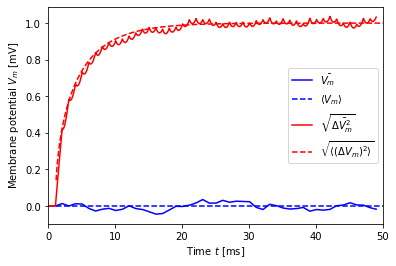

In [8]:
dt = 1.0
mu, sigma = noise_params(0., 1., dt=dt)
print("mu = {:.2f}, sigma = {:.2f}".format(mu, sigma))

V, t, ts = simulate(mu, sigma, dt=dt)
V_mean_th = V_mean(t, mu)
V_std_th = V_std(t, sigma, dt=dt)

plt.plot(t, V.mean(axis=1), 'b-', label=r'$\bar{V_m}$')
plt.plot(t + ts, V_mean_th, 'b--', label=r'$\langle V_m \rangle$')
plt.plot(t, V.std(axis=1), 'r-',  label=r'$\sqrt{\bar{\Delta V_m^2}}$')
plt.plot(t + ts, V_std_th, 'r--', label=r'$\sqrt{\langle (\Delta V_m)^2 \rangle}$')

plt.legend()
plt.xlabel('Time $t$ [ms]')
plt.ylabel('Membrane potential $V_m$ [mV]')
plt.xlim(0, 50);

Theory and simulation are in excellent agreement. The regular "drops" in the standard deviation are a consquence of the piecewise constant current and the synchronous switch in current for all neurons. It is discussed in more detail below.

#### A case with non-zero mean

We repeat the previous simulation, but now with non-zero mean current.

mu = 50.00, sigma = 111.80


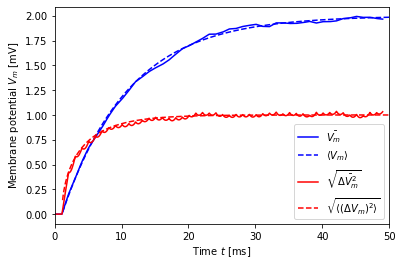

In [9]:
dt = 1.0
mu, sigma = noise_params(2., 1., dt=dt)
print("mu = {:.2f}, sigma = {:.2f}".format(mu, sigma))

V, t, ts = simulate(mu, sigma, dt=dt)
V_mean_th = V_mean(t, mu)
V_std_th = V_std(t, sigma, dt=dt)

plt.plot(t, V.mean(axis=1), 'b-', label=r'$\bar{V_m}$')
plt.plot(t + ts, V_mean_th, 'b--', label=r'$\langle V_m \rangle$')
plt.plot(t, V.std(axis=1), 'r-',  label=r'$\sqrt{\bar{\Delta V_m^2}}$')
plt.plot(t + ts, V_std_th, 'r--', label=r'$\sqrt{\langle (\Delta V_m)^2 \rangle}$')

plt.legend()
plt.xlabel('Time $t$ [ms]')
plt.ylabel('Membrane potential $V_m$ [mV]')
plt.xlim(0, 50);

We again observe excellent agreement between theory and simulation.

#### Shorter and longer switching intervals

We now repeat the previous simulation for zero mean with shorter ($\delta=0.1$ ms) and longer ($\delta=10$ ms) switching intervals.

mu = 0.00, sigma = 353.55


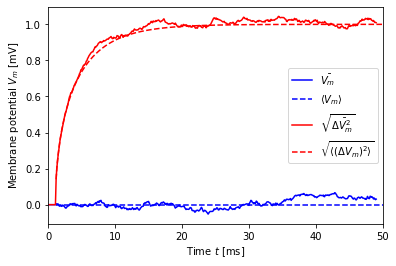

In [10]:
dt = 0.1
mu, sigma = noise_params(0., 1., dt=dt)
print("mu = {:.2f}, sigma = {:.2f}".format(mu, sigma))

V, t, ts = simulate(mu, sigma, dt=dt)
V_mean_th = V_mean(t, mu)
V_std_th = V_std(t, sigma, dt=dt)

plt.plot(t, V.mean(axis=1), 'b-', label=r'$\bar{V_m}$')
plt.plot(t + ts, V_mean_th, 'b--', label=r'$\langle V_m \rangle$')
plt.plot(t, V.std(axis=1), 'r-',  label=r'$\sqrt{\bar{\Delta V_m^2}}$')
plt.plot(t + ts, V_std_th, 'r--', label=r'$\sqrt{\langle (\Delta V_m)^2 \rangle}$')

plt.legend()
plt.xlabel('Time $t$ [ms]')
plt.ylabel('Membrane potential $V_m$ [mV]')
plt.xlim(0, 50);

Again, agreement is fine and the slight drooping artefacts are invisible, since the noise is now updated on every time step. Note also that the noise standard deviation $\sigma$ is larger (by $\sqrt{10}$) than for $\delta=1$ ms.

mu = 0.00, sigma = 35.36


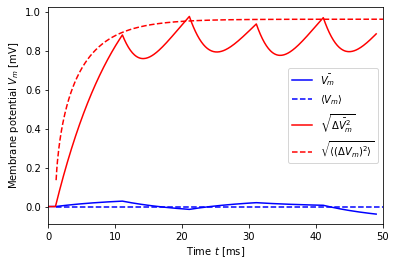

In [11]:
dt = 10.0
mu, sigma = noise_params(0., 1., dt=dt)
print("mu = {:.2f}, sigma = {:.2f}".format(mu, sigma))

V, t, ts = simulate(mu, sigma, dt=dt)
V_mean_th = V_mean(t, mu)
V_std_th = V_std(t, sigma, dt=dt)

plt.plot(t, V.mean(axis=1), 'b-', label=r'$\bar{V_m}$')
plt.plot(t + ts, V_mean_th, 'b--', label=r'$\langle V_m \rangle$')
plt.plot(t, V.std(axis=1), 'r-',  label=r'$\sqrt{\bar{\Delta V_m^2}}$')
plt.plot(t + ts, V_std_th, 'r--', label=r'$\sqrt{\langle (\Delta V_m)^2 \rangle}$')

plt.legend()
plt.xlabel('Time $t$ [ms]')
plt.ylabel('Membrane potential $V_m$ [mV]')
plt.xlim(0, 50);

For $\delta=10$, i.e., a noise switching time equal to $\tau_m$, the drooping artefact becomes clearly visible. Note that our theory developed above only applies to the points at which the input current switches, i.e., at multiples of $\delta$, beginning with the arrival of the first current at the neuron (at delay plus one time step). At those points, agreement with theory is good.

##### Why does the standard deviation dip between current updates?

In the last case, where $\delta = \tau_m$, the dips in the membrane potential between changes in the noise current become quite large. They can be explained as follows. For large $\delta$, we have at the end of a $\delta$-interval for neuron $n$ membrane potential $V_n(t_{j})\approx I_{n,j-1}\tau/C$ and these values will be distributed across neurons with standard deviation $\sqrt{\langle (\Delta V_m)^2 \rangle}$. Then, input currents of all neurons switch to new values $I_{n,j}$ and the membrane potential of each neuron now evolves towards $V_n(t_{j+1})\approx I_{n,j}\tau/C$. Since current values are independent of each other, this means that membrane-potential trajectories criss-cross each other, constricting the variance of the membrane potential before they approach their new steady-state values, as illustrated below.

You should therefore use short switching times $\delta$.

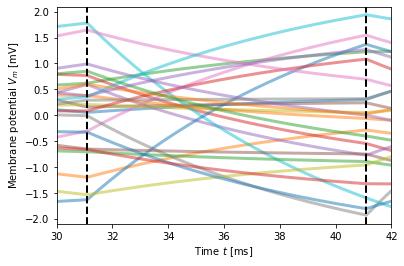

In [12]:
plt.plot(t, V[:, :25], lw=3, alpha=0.5);
plt.plot([31.1, 31.1], [-3, 3], 'k--', lw=2)
plt.plot([41.1, 41.1], [-3, 3], 'k--', lw=2)
plt.xlabel('Time $t$ [ms]')
plt.ylabel('Membrane potential $V_m$ [mV]')
plt.xlim(30, 42);
plt.ylim(-2.1, 2.1);

### Autocorrelation

We briefly look at the autocorrelation of the membrane potential for three values of $\delta$.

In [13]:
from scipy.signal import fftconvolve
from statsmodels.tsa.stattools import acf

def V_autocorr(V_mean, V_std, dt=1., tau_m=10.):
    'Returns autocorrelation of membrane potential and pertaining time axis.'

    mu, sigma = noise_params(V_mean, V_std, dt=dt, tau_m=tau_m)
    V, t, ts = simulate(mu, sigma, dt=dt, tau_m=tau_m, t_max=5000., N=20)

    # drop the first second
    V = V[t>1000., :]
    
    # compute autocorrelation columnwise, then average over neurons
    nlags = 1000
    nt, nn = V.shape
    acV = np.zeros((nlags+1, nn))
    for c in range(V.shape[1]):
        acV[:, c] = acf(V[:, c], unbiased=True, nlags=1000, fft=True)
        #fftconvolve(V[:, c], V[::-1, c], mode='full') / V[:, c].std()**2
    acV = acV.mean(axis=1)

    # time axis
    dt = t[1] - t[0]
    acT = np.arange(0, nlags+1) * dt
    
    return acV, acT

In [14]:
acV_01, acT_01 = V_autocorr(0., 1.,  0.1)
acV_10, acT_10 = V_autocorr(0., 1.,  1.0)
acV_50, acT_50 = V_autocorr(0., 1.,  5.0)

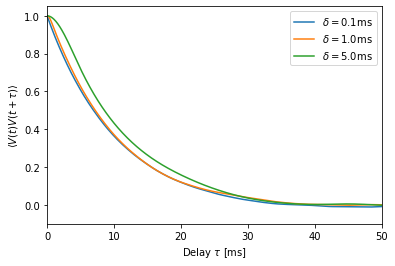

In [15]:
plt.plot(acT_01, acV_01, label=r'$\delta = 0.1$ms');
plt.plot(acT_10, acV_10, label=r'$\delta = 1.0$ms');
plt.plot(acT_50, acV_50, label=r'$\delta = 5.0$ms');

plt.xlim(0, 50);
plt.ylim(-0.1, 1.05);
plt.legend();
plt.xlabel(r'Delay $\tau$ [ms]')
plt.ylabel(r'$\langle V(t)V(t+\tau)\rangle$');

We see that the autocorrelation is clearly dominated by the membrane time constant of $\tau_m=10$ ms. The switching time $\delta$ has a lesser effect, although it is noticeable for $\delta=5$ ms.

#### Different membrane time constants

To document the influence of the membrane time constant, we compute the autocorrelation function for three different $\tau_m$.

In [16]:
acV_t01, acT_t01 = V_autocorr(0., 1.,  0.1, 1.)
acV_t05, acT_t05 = V_autocorr(0., 1.,  0.1, 5.)
acV_t10, acT_t10 = V_autocorr(0., 1.,  0.1, 10.)

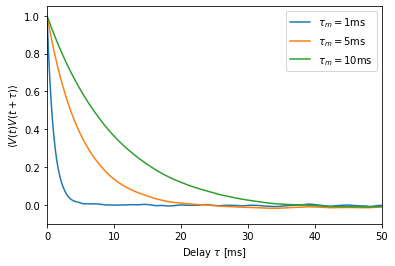

In [17]:
plt.plot(acT_t01, acV_t01, label=r'$\tau_m = 1$ms');
plt.plot(acT_t05, acV_t05, label=r'$\tau_m = 5$ms');
plt.plot(acT_t10, acV_t10, label=r'$\tau_m = 10$ms');

plt.xlim(0, 50);
plt.ylim(-0.1, 1.05);
plt.legend();
plt.xlabel(r'Delay $\tau$ [ms]')
plt.ylabel(r'$\langle V(t)V(t+\tau)\rangle$');